# Dual Rotating Retarder Mueller Polarimetry

_written by Jaren N. Ashcraft_

In order to measure how a system transforms the polarization state of light, we can measure the system's Mueller Matrix. There are a host of different methods by which we can do so. In this tutorial, we review the popular Dual Rotating Retarder Polarimeter (DRRP) for full Mueller matrix polarimetry. This consists of:

- a source
- a linear polarizer at a fixed angle
- a quarter-wave plate that can rotate
- the system you are trying to measure the mueller matrix of
- a quarter-wave plate that can rotate
- a linear polarizer at a fixed angle
- a detector to measure power

The theory of this polarimeter is covered in Chipman, and also Azzam, but is reproduced in brief here. Our first polarizer/waveplate pair forms our *polarization state generator* (PSG). The latter pair forms our *polarization state analyzer* (PSA). The first waveplate must rotate $N_{meas} > 16$ times at some angular step size $\delta\theta$ to completely determine the Mueller matrix. The second waveplate must also rotate $N_{meas}$ times, but at five times the step size $5\delta\theta$.

For each $\delta\theta$ we record the power on the detector. We next must understand that detectors can only measure power! This means, that it effectively measures the first row of the PSA matrix and the first column of the PSG matrix. The reason for that is revealed in the Mueller calculus, which I've left as an exercise to the reader below*

$$\mathbf{S}_{out} = [\mathbf{PSA}] \mathbf{M}_{system} [\mathbf{PSG}] \mathbf{S_{0}}$$

For each measurement iteration we compute our PSA and PSG, and then store those results in our polarimetric data reduction matrix $\mathbf{W}$. This is an $N_{meas} \times 16$ matrix that contains what our PSA and PSG are doing. $\mathbf{W}$ is given by:

$$\mathbf{W} = [\mathbf{PSA}_{0,j}] \otimes [\mathbf{PSG}_{i,0}]$$

Where $i,j$ are the row and column indices, respectively, and $\otimes$ is the Kronecker product. For each measurement, we record the power on the detector and store it in a vector that is $N_{meas}$ long, called $\mathbf{P}$, and we computpe the unraveled Mueller matrix using the following relation:

$$\mathbf{M}_{meas} = \mathbf{W}^{-1}\mathbf{P}$$

For the case where $N_{meas} > 16$, you must use the moore-penrose pseudo inverse to invert $\mathbf{W}$. Now that the theory is out of the way, let's test it out! We begin by constructing a random Mueller matrix composed of a polarizer and retarder:

*aren't I the worst?

In [45]:
import numpy as np
from katsu.mueller import linear_polarizer,linear_retarder

M_to_measure = linear_retarder(np.random.random(),np.random.random()) @ linear_polarizer(np.random.random())
display(M_to_measure)

array([[0.5       , 0.29399553, 0.40443371, 0.        ],
       [0.28578716, 0.16804029, 0.23116392, 0.        ],
       [0.40673081, 0.23915408, 0.3289913 , 0.        ],
       [0.05381217, 0.03164107, 0.04352691, 0.        ]])

## Performing a simulated measurement
We begin by creating a simulated series of power measurements by setting up our polarization state generators and analyzers. We then propagate a Stokes vector through this system and grab the $I$ parameter in order to observe the power as we step through the experiment.

In [46]:
from katsu.mueller import stokes_from_parameters

# How much more the PSA rotates than the PSG
PSA_ANGULAR_INCREMENT = 5

# katsu has a simulator built-in, so let's try use that
thetas = np.linspace(0,2*np.pi,16) # 16 measurements between 0 and pi

# set up polarization state generator
psg_polarizer = linear_polarizer(0, shape=thetas.shape)
psg_retarder  = linear_retarder(thetas, np.pi / 2, shape=thetas.shape)
PSG = psg_retarder @ psg_polarizer

# set up polarization state generator
psa_polarizer = linear_polarizer(0, shape=thetas.shape)
psa_retarder  = linear_retarder(PSA_ANGULAR_INCREMENT * thetas, np.pi / 2, shape=thetas.shape)
PSA = psa_polarizer @ psa_retarder

# set up system Mueller matrix
Msys = PSA @ M_to_measure @ PSG

# propagate Stokes vector to get power
Sin = stokes_from_parameters(1, 0, 0, 0)
Sout = Msys @ Sin
power_measured = Sout[..., 0, 0]

Below we plot the power observed as the PSG and PSA step in angular increments of $\delta\theta$ and $5\delta\theta$, respectively.

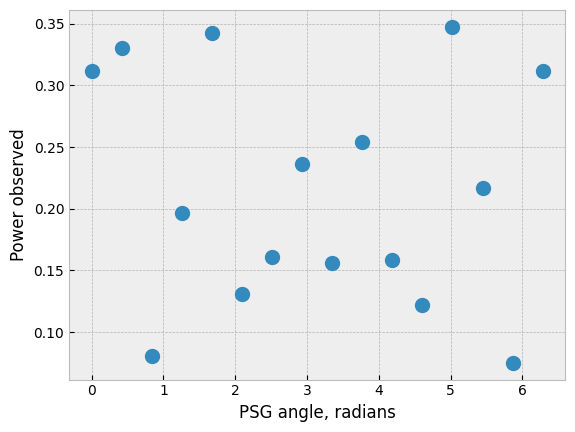

In [47]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

plt.figure()
plt.ylabel('Power observed')
plt.xlabel('PSG angle, radians')
plt.plot(thetas, power_measured, marker='o', linestyle='None', markersize=10)
plt.show()

In katsu.polarimetry we have the data reduction available to convert this power measurement into a Mueller matrix measured. The full_mueller_polarimetry function takes dictionaries as inputs which store the state of the instrument. Below we show the defaults, but this freedom enables the flexibility necessary to use this technique accurately in the laboratory.

In [48]:
from katsu.polarimetry import full_mueller_polarimetry

# The angles all optics begin at
starting_angles={'psg_polarizer': 0,
                 'psg_waveplate': 0,
                 'psa_waveplate': 0,
                 'psa_polarizer': 0}

starting_polarization={'psg_Tmin': 0,
                       'psg_ret': np.pi / 2,
                       'psa_Tmin': 0,
                       'psa_ret': np.pi / 2}

M_measured = full_mueller_polarimetry(thetas, power_measured, PSA_ANGULAR_INCREMENT,
                                      starting_angles=starting_angles,
                                      starting_polarization=starting_polarization)

In [52]:
print('Mueller Matrix Original')
print(M_to_measure)
print('-'*30)
print('Mueller Matrix Measured')
print(M_measured)
print('-'*30)
print('Percent Difference')
print(100*(M_to_measure-M_measured)/M_to_measure)
print('-'*30)

Mueller Matrix Original
[[0.5        0.29399553 0.40443371 0.        ]
 [0.28578716 0.16804029 0.23116392 0.        ]
 [0.40673081 0.23915408 0.3289913  0.        ]
 [0.05381217 0.03164107 0.04352691 0.        ]]
------------------------------
Mueller Matrix Measured
[[ 5.00000000e-01  2.93995530e-01  4.04433713e-01 -5.96744876e-16]
 [ 2.85787156e-01  1.68040293e-01  2.31163922e-01  6.10622664e-16]
 [ 1.02871029e-01  6.04872455e-02  8.32090246e-02 -5.34294831e-16]
 [ 2.05742058e-01  1.20974491e-01  1.66418049e-01  2.49800181e-16]]
------------------------------
Percent Difference
[[-2.22044605e-13 -4.72040776e-13  3.84318167e-13             inf]
 [ 6.21566365e-13  1.04058451e-12 -2.40137608e-13            -inf]
 [ 7.47078346e+01  7.47078346e+01  7.47078346e+01             inf]
 [-2.82333711e+02 -2.82333711e+02 -2.82333711e+02            -inf]]
------------------------------


C:\Users\Work\AppData\Local\Temp\ipykernel_17996\1858271723.py:8: RuntimeWarning: divide by zero encountered in divide
  print(100*(M_to_measure-M_measured)/M_to_measure)


Pardon the rightmost column blowing up, but those were all zeros anyway. We successfully recover some of the information for the top two rows but not the bottom, can this be fixed with more measurements?

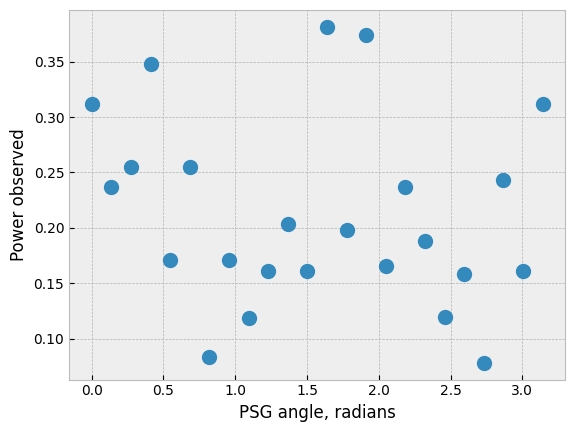

Mueller Matrix Original
[[0.5        0.29399553 0.40443371 0.        ]
 [0.28578716 0.16804029 0.23116392 0.        ]
 [0.40673081 0.23915408 0.3289913  0.        ]
 [0.05381217 0.03164107 0.04352691 0.        ]]
------------------------------
Mueller Matrix Measured
[[ 5.00000000e-01  2.93995530e-01  4.04433713e-01 -1.38777878e-16]
 [ 2.85787156e-01  1.68040293e-01  2.31163922e-01 -5.55111512e-17]
 [ 4.06730810e-01  2.39154080e-01  3.28991304e-01 -2.01227923e-16]
 [ 5.38121679e-02  3.16410736e-02  4.35269098e-02 -1.11022302e-16]]
------------------------------
Percent Difference
[[-8.88178420e-14  3.77632621e-14  2.47061679e-13             inf]
 [-1.16543693e-13 -8.25860725e-14 -2.88165130e-13             inf]
 [-4.09443911e-14 -8.12401065e-14 -1.68731363e-13             inf]
 [ 4.12628990e-13 -1.18422110e-12 -7.65197688e-13             inf]]
------------------------------


C:\Users\Work\AppData\Local\Temp\ipykernel_17996\3633839214.py:40: RuntimeWarning: divide by zero encountered in divide
  print(100*(M_to_measure-M_measured)/M_to_measure)


In [54]:
# katsu has a simulator built-in, so let's try use that
thetas = np.linspace(0, np.pi, 24) # 24 measurements between 0 and pi

# set up polarization state generator
psg_polarizer = linear_polarizer(0, shape=thetas.shape)
psg_retarder  = linear_retarder(thetas, np.pi / 2, shape=thetas.shape)
PSG = psg_retarder @ psg_polarizer

# set up polarization state generator
psa_polarizer = linear_polarizer(0, shape=thetas.shape)
psa_retarder  = linear_retarder(PSA_ANGULAR_INCREMENT * thetas, np.pi / 2, shape=thetas.shape)
PSA = psa_polarizer @ psa_retarder

# set up system Mueller matrix
Msys = PSA @ M_to_measure @ PSG

# propagate Stokes vector to get power
Sin = stokes_from_parameters(1, 0, 0, 0)
Sout = Msys @ Sin
power_measured = Sout[..., 0, 0]

plt.figure()
plt.ylabel('Power observed')
plt.xlabel('PSG angle, radians')
plt.plot(thetas, power_measured, marker='o', linestyle='None', markersize=10)
plt.show()

# perform Mueller matrix measurement
M_measured = full_mueller_polarimetry(thetas, power_measured, PSA_ANGULAR_INCREMENT,
                                      starting_angles=starting_angles,
                                      starting_polarization=starting_polarization)

print('Mueller Matrix Original')
print(M_to_measure)
print('-'*30)
print('Mueller Matrix Measured')
print(M_measured)
print('-'*30)
print('Percent Difference')
print(100*(M_to_measure-M_measured)/M_to_measure)
print('-'*30)

Indeed it can! Experimentally I've found that 24 is a good minimum number of measurements to get accurate measurements of the Mueller matrix in simulation. In the laboratory, the presence of noise further complicates things, so more measurements are needed for more accurate polarimetry. But this is the subject of future investigations!